In [1]:
import pandas as pd
import numpy as np

## The input data

In [240]:
X_train = np.load('data/data_train/data_train.npy', mmap_mode='r')

print("The training data is made of {} images of {}x{} pixels".format(
    *X_train.shape))

n_img = len(X_train)

The training data is made of 619 images of 400x400 pixels


In [241]:
df = pd.read_csv('data/Data_train/data_train_labels.csv')
df.head()

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 2 columns):
id       619 non-null int64
label    619 non-null int64
dtypes: int64(2)
memory usage: 9.8 KB


The labels consist of a `pandas.DataFrame` containing for each row :
- `id` : the unique identifier of the image
- `label` : the class to which belongs the observed nevus :
    - `0 : benign`
    - `1 : malignant`

,Label,Count,Name
0,0,324,Benign
1,1,295,Malignant


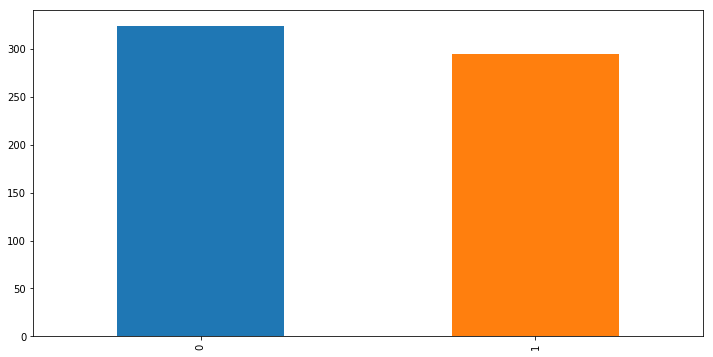

In [243]:
df['label'].value_counts().sort_index().plot.bar(figsize=(12, 6))

labels_name = ['Benign','Malignant']

labels_count_df = df.groupby(['label']).agg('count').reset_index()
labels_count_df['name'] = pd.Series(data=labels_name)
labels_count_df.columns = ['Label','Count','Name']
labels_count_df

We can analyze the dataset metadata to better understand the labels distribution among the observed population.

In [244]:
meta = pd.read_csv('data/metadata.csv')
meta = meta[['meta.clinical.age_approx', 'meta.clinical.sex', 'meta.clinical.benign_malignant']]
meta.rename({'meta.clinical.age_approx':'age', 'meta.clinical.sex':'sex', 'meta.clinical.benign_malignant':'label'}, axis=1, inplace=True)
meta['label'].loc[meta['label'] != 'benign'] = 'malignant'
meta.head()

C:\Users\Jean\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,age,sex,label
0,55.0,female,benign
1,30.0,female,benign
2,60.0,female,malignant
3,30.0,male,benign
4,80.0,male,malignant


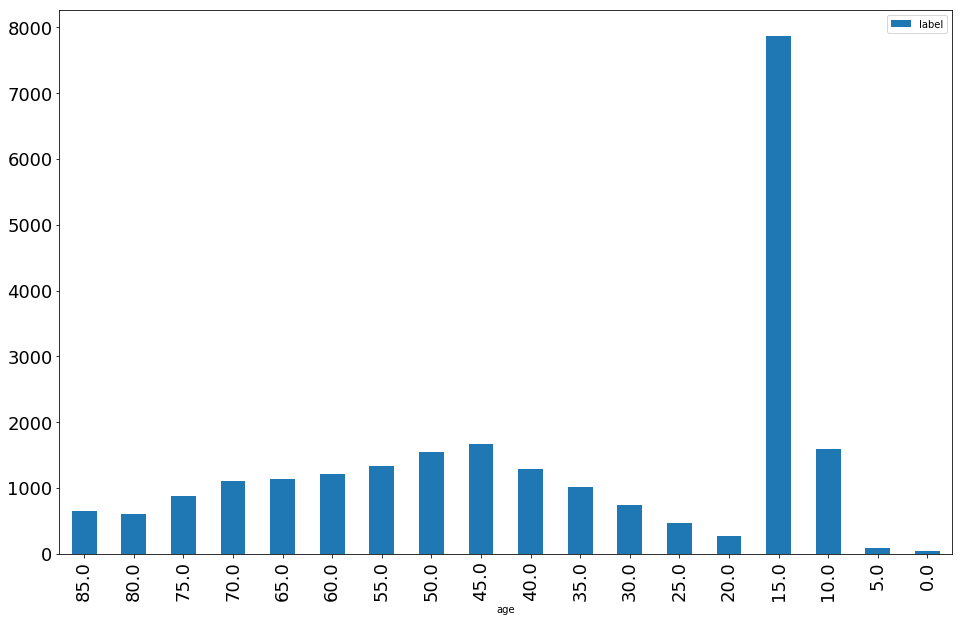

In [245]:
meta.groupby('age').count()[['label']].sort_values(
    'age', ascending=False).reset_index().plot.bar(
    x='age', figsize=(16, 10), fontsize=18);

However, these data are not provided for the current challenge. But the age and sex of a patient could be filled on a mobile app to make the melanoma detection model better.

Here, we display one image for each class.

In [246]:
idx_list = [10, 515]

In [247]:
import matplotlib.pyplot as plt
%matplotlib inline

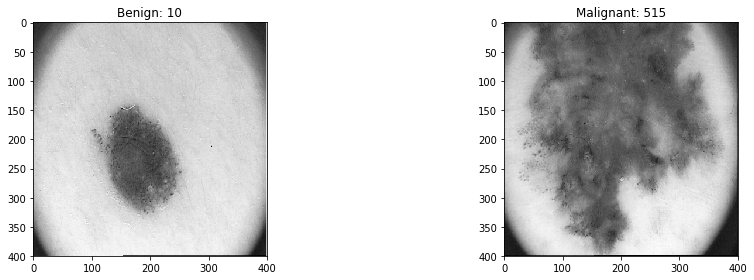

In [248]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
for i, idx in enumerate(idx_list):
    axes[i].imshow(X_train[idx], cmap='Greys_r')
    axes[i].set_title(labels_name[i] + ': %d' % idx)
fig.tight_layout()

## Image preprocessing

As most nevus are in the middle of the image, here we decide to crop the images. We create 250x250 centered images

In [249]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

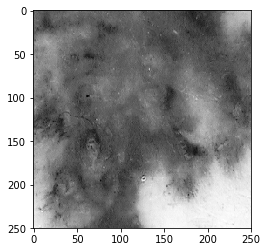

In [250]:
croped_melanoma = crop_center(X_train[515], 250, 250)
plt.imshow(croped_melanoma, cmap='Greys_r')

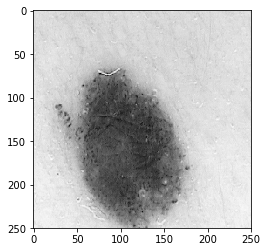

In [251]:
croped_nevus = crop_center(X_train[10], 250, 250)
plt.imshow(croped_nevus, cmap='Greys_r')

## Exploratory image analysis

### Size

One characteristic of a melanoma is its size. Usually big moles are malignant. Let us compare two of them as an example. Here, we count the number of dark pixels in each case.

In [252]:
from scipy import ndimage

def count_dark_pixels(img):

    blobs = img < 160
    labels = ndimage.label(blobs)[0]

    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 5))
    ax[0].imshow(img, cmap='Greys_r')
    ax[1].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)

    fig.tight_layout()
    plt.show()
    
    return blobs

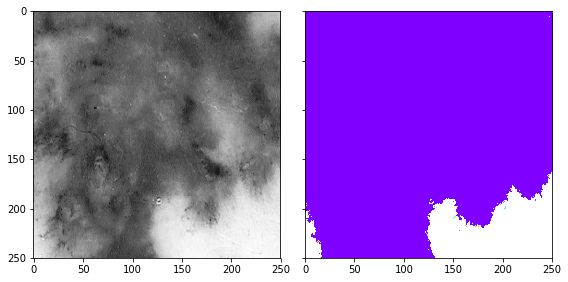

Number of dark pixels (Melanoma): 55312


In [253]:
print('Number of dark pixels (Melanoma):', np.sum(count_dark_pixels(croped_melanoma)))

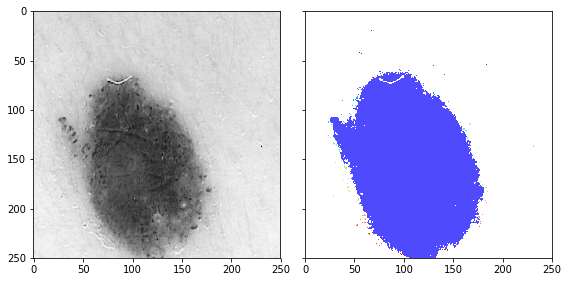

Number of dark pixels (Nevus): 19034


In [254]:
print('Number of dark pixels (Nevus):', np.sum(count_dark_pixels(croped_nevus)))

Here, we compare sizes distribution for benign and malignant nevus over the whole dataset.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA4298D128>,
      dtype=object)

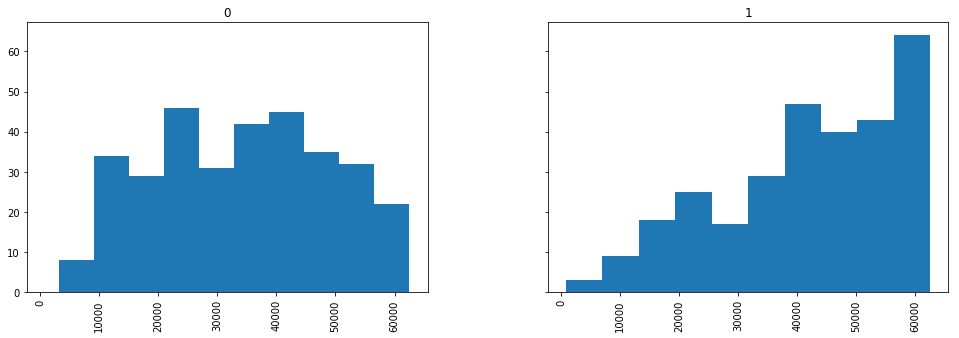

In [255]:
blobs_array = np.zeros((X_train.shape[0]))
for i,x in enumerate(X_train):
    croped = crop_center(x, 250, 250)
    blobs_array[i] = np.sum(croped < 160)

df['cnt_dark_pixel'] = pd.Series(blobs_array)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 5))
df.hist(column='cnt_dark_pixel', by='label', ax=axes)

### Borders

One of the main difference between a nevus and a melanoma is their shape. A melanoma usually has irregular borders with edges and corners. In image analysis, this is what we call image compactnes. Here, we visually compare shape compactness between a benign nevus and a malignant one, taking two new observations.

In [256]:
from skimage import measure

def draw_contours(img, i):
    contours = measure.find_contours(img, 170, positive_orientation='high')
    contour = max(contours, key=len)
    
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
    ax.set_title(labels_name[i])
    plt.show()

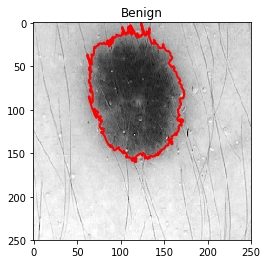

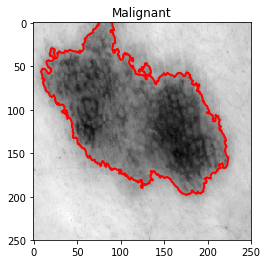

In [257]:
croped_nevus = crop_center(X_train[11], 250, 250)
draw_contours(croped_nevus, 0)

croped_melanoma = crop_center(X_train[550], 250, 250)
draw_contours(croped_melanoma, 1)